In [28]:
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_rows', 100)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from charts import plot_line
from charts import plot_bar
from features import add_variables_covid
from features import add_variables_apple

%matplotlib inline

# World Bank Data

In [3]:
import world_bank_data as wb

In [4]:
countries = wb.get_countries()

In [5]:
# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)
population

Country
ARB    419790588.0
CSS      7358965.0
CEB    102511922.0
          ...     
YEM     28498687.0
ZMB     17351822.0
ZWE     14439018.0
Name: SP.POP.TOTL, Length: 264, dtype: float64

In [6]:
# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population.head(1)

,region,country,population
id,,,
ABW,Latin America & Caribbean,Aruba,105845.0


In [7]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type'])]
    
    df_region['dates'] = pd.to_datetime(df_region.index)
    df_region.set_index('dates', inplace=True)
    df_region = df_region.astype('float')
    
    return df_region

In [8]:
date_apple = '2020-04-25'
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")

dfapple = pd.read_csv(f"data/AppleMobilty/applemobilitytrends-{date_apple}.csv")

dfcovid_conf = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

df_germany = pd.read_csv("data/RKI-reports.csv")

### Add index to RKI data

In [9]:
df_germany['date'] = df_germany['date'].astype('datetime64[ns]')
df_germany = df_germany.sort_values('date', ascending=True)
df_germany.set_index('date', inplace=True)

### Transpose Confirmed Cases

In [10]:
dfcovid_conf_t = dfcovid_conf.T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['Country/Region', :] + "_" + dfcovid_conf_t.loc['Province/State', :].astype(str)

dfcovid_conf_t.drop(['Country/Region'], axis=0, inplace=True)

df_country_coords = dfcovid_conf_t.loc[['Lat', 'Long'], :]

dfcovid_conf_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)
dfcovid_conf_t = dfcovid_conf_t.astype(float)

### Transpose Dead Cases

In [11]:
dfcovid_dead_t = dfcovid_dead.T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['Country/Region', :] + "_" + dfcovid_dead_t.loc['Province/State', :].astype(str)
dfcovid_dead_t.drop(['Country/Region'], axis=0, inplace=True)


dfcovid_dead_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)
dfcovid_dead_t = dfcovid_dead_t.astype(float)


In [12]:
# import inspect
# source_DF = inspect.getsource(add_weekday_weekend)
# print(source_DF)

### Check max dates in index

### Add weekend Column

# Apple Mobility DF

## Transpose Mobility and Filter Region Create lagged and % variables

In [13]:
dfapple_region = apple_filter_region(dfapple, "Hamburg").copy()
dfapple_region = add_variables_apple(dfapple_region)

In [14]:
print("Mobility max date:", max(dfapple_region.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))
print("RKI max date", max(df_germany.index))

Mobility max date: 2020-04-25 00:00:00
Covi world max date 2020-04-26 00:00:00
Covi world max date 2020-04-26 00:00:00
RKI max date 2020-04-26 00:00:00


In [15]:
dfapple_region.head()

transportation_type,driving,transit,walking,transit_avg3,walking_avg3,driving_avg3,transit_l1,walking_l1,driving_l1,transit_l6,walking_l6,driving_l6,change_pct_transit_l6,change_pct_walking_l6,change_pct_driving_l6,change_pct_transit,change_pct_walking,change_pct_driving
dates,,,,,,,,,,,,,,,,,,
2020-01-13,100.00,100.00,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14,101.73,98.86,101.55,NaN,NaN,NaN,100.00,100.00,100.00,NaN,NaN,NaN,NaN,NaN,NaN,0.988600,1.015500,1.017300
2020-01-15,102.87,99.74,110.08,99.0,103.0,102.0,98.86,101.55,101.73,NaN,NaN,NaN,NaN,NaN,NaN,1.008901,1.083998,1.011206
2020-01-16,106.65,102.18,116.16,100.0,109.0,104.0,99.74,110.08,102.87,NaN,NaN,NaN,NaN,NaN,NaN,1.024464,1.055233,1.036745
2020-01-17,112.44,115.69,139.82,105.0,121.0,107.0,102.18,116.16,106.65,NaN,NaN,NaN,NaN,NaN,NaN,1.132218,1.203685,1.054290


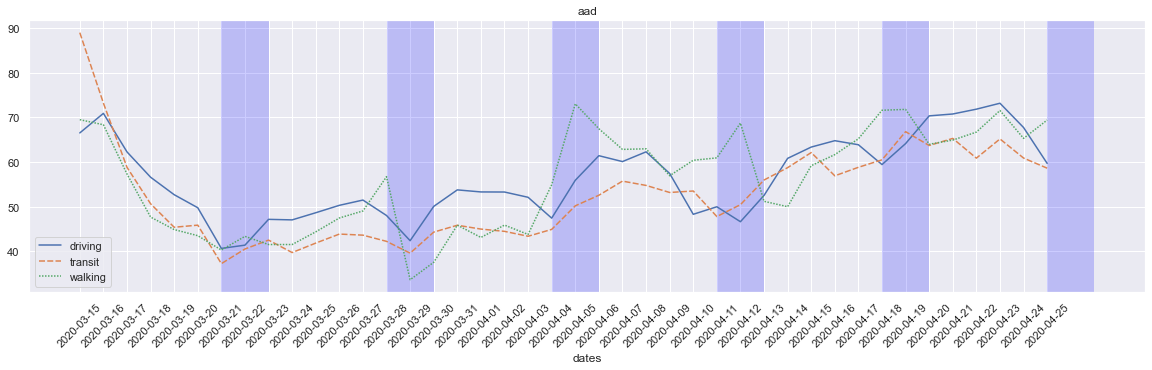

In [16]:
plot_line(dfapple_region, columns=['driving','transit','walking'], date_cutoff='2020-03-15', title='aad')

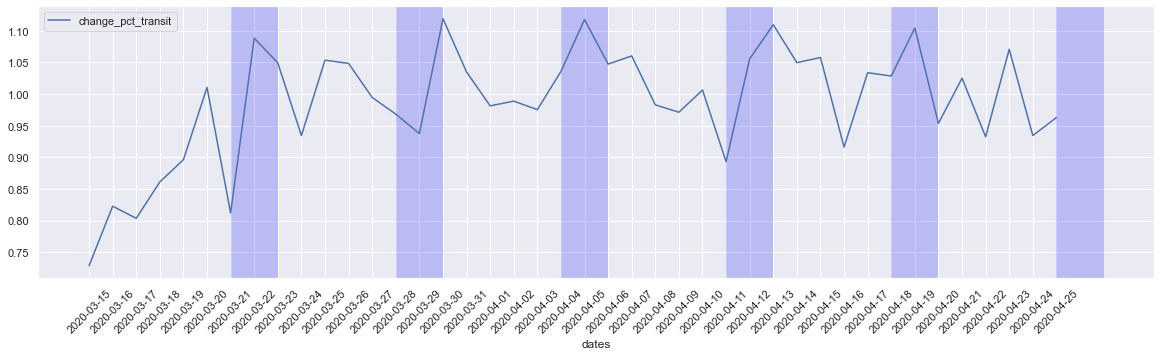

In [17]:
plot_line(dfapple_region, columns=['change_pct_transit'], date_cutoff='2020-03-15')

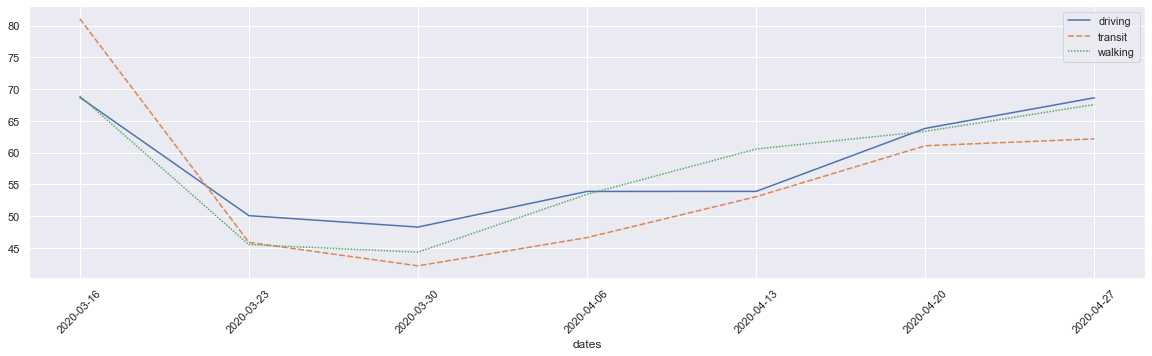

In [18]:
plot_line(dfapple_region, columns=['driving','transit','walking'], resample='W-MON', date_cutoff='2020-03-15')

# Robert Koch Institute DF

## Filter region (Hamburg) & Create lagged and % variables

In [19]:
df_hamburg = df_germany.loc[df_germany.land == 'Hamburg', :].copy()
df_hamburg.drop('data', axis=1, inplace=True)

df_hamburg = add_variables_covid(df_hamburg, 'confirmed', population=1822000)
df_hamburg = add_variables_covid(df_hamburg, 'dead', population=1822000)

----

In [20]:
# df_hamburg.sort_index(ascending=False).head(5).T

# Explore Plots

# Hamburg

In [21]:
df_hamburg.loc[:,['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3']]

,confirmed_doubling_days,confirmed_doubling_days_3w,confirmed_doubling_days_3w_avg3
date,,,
2020-03-18,0.000,0.000,NaN
2020-03-19,3.689,0.000,NaN
2020-03-20,2.273,0.000,0.0
...,...,...,...
2020-04-24,41.607,18.443,38.0
2020-04-25,72.268,29.424,21.0
2020-04-26,100.000,41.050,30.0


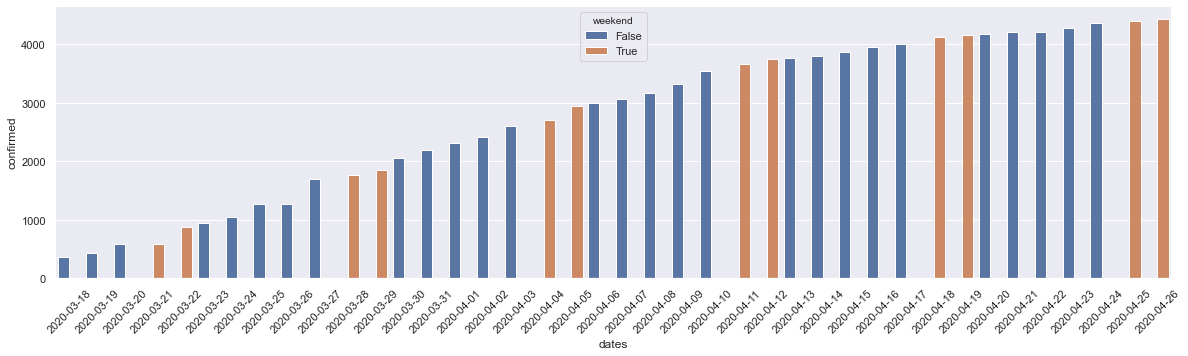

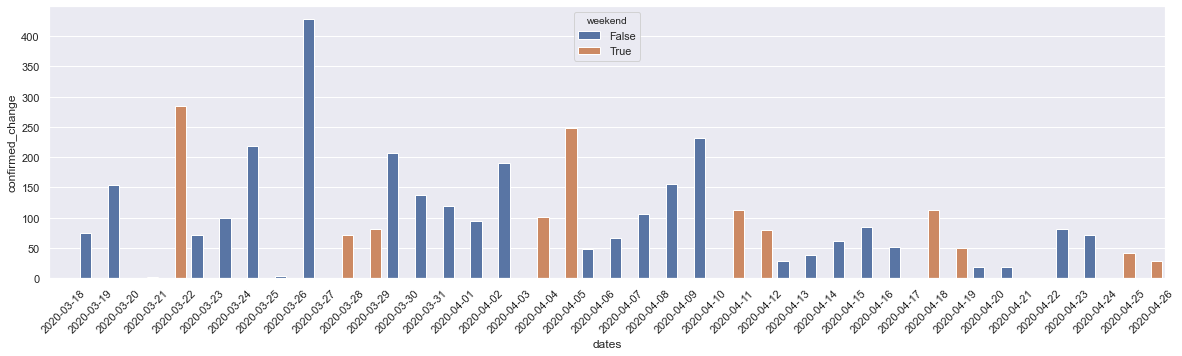

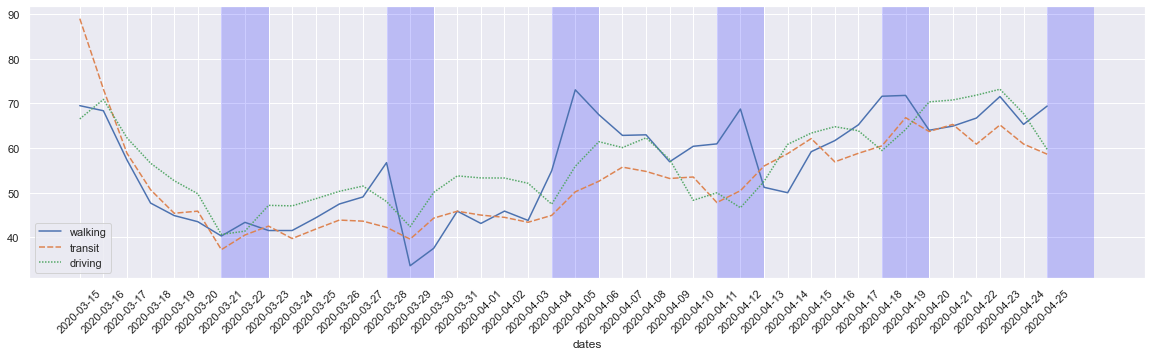

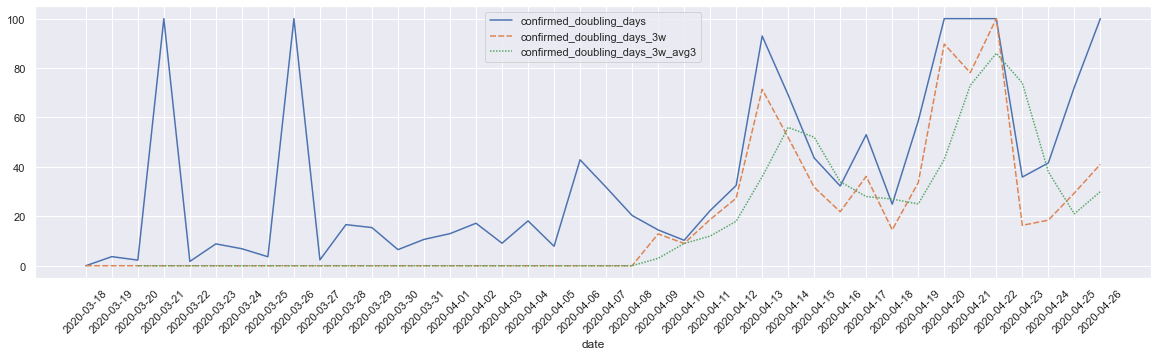

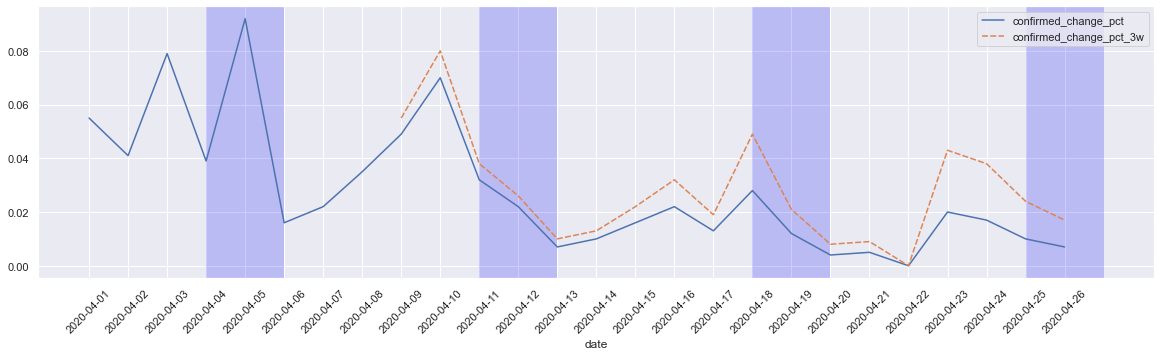

In [27]:
plot_bar(df_hamburg, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_hamburg, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Hamburg"), columns=['walking', 'transit','driving'], date_cutoff='2020-03-15')
dfapple_region = add_variables_apple(dfapple_region)
plot_line(df_hamburg, columns=['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3'])
plot_line(df_hamburg, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-04-01')
# plot_line(df_hamburg, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-04-01')

---

In [24]:
df_russia_dead = dfcovid_dead_t.loc[dfcovid_dead_t.index >= '2020-03-15', ['Russia_nan']]
df_russia_dead.columns = ['dead']
df_russia = add_variables_covid(df_russia_dead, column='dead', population=population['RUS'])

# Russia

In [25]:
df_russia = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['Russia_nan']]
df_russia.columns = ['confirmed']
df_russia = add_variables_covid(df_russia, population=population['RUS'])

KeyError: "None of [Index(['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], dtype='object')] are in the [columns]"

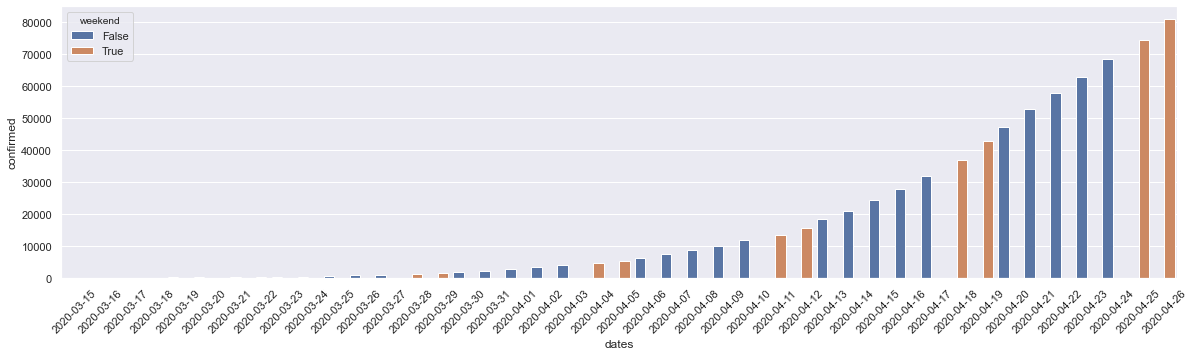

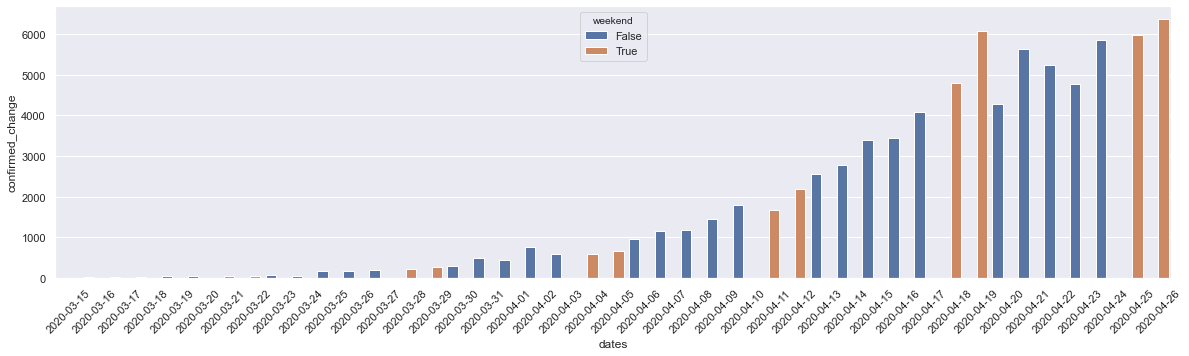

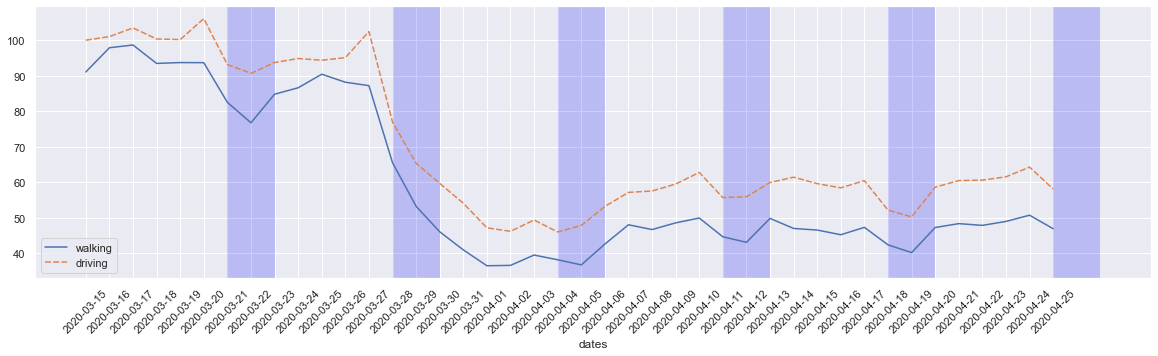

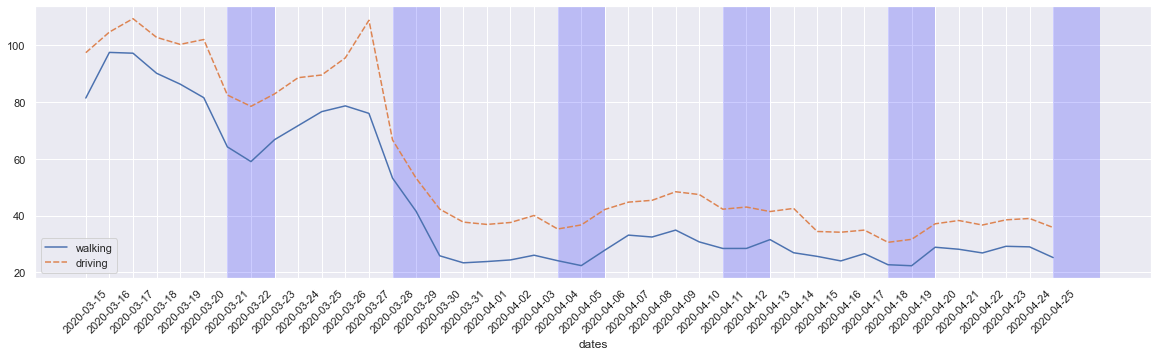

In [26]:
plot_bar(df_russia, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_russia, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Russia"), columns=['walking','driving'], date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Moscow"), columns=['walking','driving'], date_cutoff='2020-03-15')
# plot_line(df_russia, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_russia, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_russia, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# Sweden

In [ ]:
df_sweden = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['Sweden_nan']]
df_sweden.columns = ['confirmed']
df_sweden = add_variables_covid(df_sweden, population=population['SWE'])

plot_bar(df_sweden, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_sweden, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Sweden"), columns=['walking', 'transit','driving'], date_cutoff='2020-03-15')
# plot_line(df_sweden, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_sweden, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_sweden, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# UK

In [ ]:
df_uk = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['United Kingdom_nan']]
df_uk.columns = ['confirmed']
df_uk = add_variables_covid(df_uk, population=population['GBR'])

plot_bar(df_uk, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_uk, columns='confirmed_change', date_cutoff='2020-03-15')
# plot_line(df_uk, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_uk, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_uk, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# US

In [ ]:
df_us = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['US_nan']]
df_us.columns = ['confirmed']
df_us = add_variables_covid(df_us, population=population['USA'])

plot_bar(df_us, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_us, columns='confirmed_change', date_cutoff='2020-03-15')
# plot_line(df_uk, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_us, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_uk, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# Compare Infections

In [ ]:
def add_day_since(df, colunm, cutoff):
#     df = df_hamburg.loc[:,['confirmed']]
    df['day_since'] = 0
    df['day_since'] = df.apply(lambda x: x['day_since'] + 1 if x[colunm] > cutoff else 0, axis=1)
    df['day_since'] = df['day_since'].cumsum()
    return df

In [ ]:
df_hamburg.head()

In [ ]:
df_hamburg = add_day_since(df_hamburg, 'confirmed', 1000)
df_sweden = add_day_since(df_sweden, 'confirmed', 1000)
df_us = add_day_since(df_us, 'confirmed', 1000)
df_uk = add_day_since(df_uk, 'confirmed', 1000)
df_russia = add_day_since(df_russia, 'confirmed', 1000)

In [ ]:
def join_series_day_since(dfs:dict, column):
    list_to_join = []
    for k in dfs.keys():
        df = dfs[k].loc[dfs[k].day_since > 0, [column] + ['day_since']]
        df.columns = [k] + ['day_since']
        df.set_index('day_since', inplace=True)
        list_to_join.append(df)
    
    return pd.concat(list_to_join, axis=1)

In [ ]:
countries = {'Hamburg':df_hamburg,
             "Russia": df_russia,
             "UK": df_uk,
             "US": df_us,
             "Sweden": df_sweden,
             }
confirmed_per_mil = join_series_day_since(countries, 'confirmed_per_mil')
confirmed_change_per_100k = join_series_day_since(countries, 'confirmed_change_per_100k')

In [ ]:
plot_line(confirmed_per_mil, columns=confirmed_per_mil.columns, title='Confirmed Cases per Million')

In [ ]:
confirmed = join_series_day_since(countries, 'confirmed')
plot_line(confirmed, columns=confirmed.columns, title='Confirmed Cases')

In [ ]:

plot_bar(df_hamburg, columns='confirmed_change_per_100k', date_cutoff='2020-03-15', title='Hamburg')
plot_bar(df_sweden, columns='confirmed_change_per_100k', date_cutoff='2020-03-15', title='Sweden')
plot_bar(df_us, columns='confirmed_change_per_100k', date_cutoff='2020-03-15', title='US')
plot_bar(df_uk, columns='confirmed_change_per_100k', date_cutoff='2020-03-15', title='UK')
plot_bar(df_russia, columns='confirmed_change_per_100k', date_cutoff='2020-03-15', title='Russia')

plot_bar(df_hamburg, columns='confirmed_per_mil', date_cutoff='2020-03-15', title='Hamburg')
plot_bar(df_sweden, columns='confirmed_per_mil', date_cutoff='2020-03-15', title='Sweden')
plot_bar(df_us, columns='confirmed_per_mil', date_cutoff='2020-03-15', title='US')
plot_bar(df_uk, columns='confirmed_per_mil', date_cutoff='2020-03-15', title='UK')
plot_bar(df_russia, columns='confirmed_per_mil', date_cutoff='2020-03-15', title='Russia')

## Join RKI and Mobility

In [ ]:
df_joined = dfapple_region.join(df_hamburg)

In [ ]:
# df_joined.loc['2020-03-18':'2020-03-30', ['change_%_conf','change_%_conf_avg3', 'transit', 'walking', 'driving']]

In [ ]:
dfcovid_conf.loc[dfcovid["Country/Region"] == 'Russia']